<a href="https://colab.research.google.com/github/LongNguyen1984/DeepLearning/blob/master/Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
from random import random
import os
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy import expand_dims
from numpy.random import randint
from numpy.random import randn, random
#from keras.datasets.fashion_mnist import load_data
from keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Flatten, Dropout, Dense, Reshape
#import tensorflow_addons as tfa
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend
from keras.layers import Lambda
from keras import backend
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Multiply, Subtract

# Siamese Network for similarities checking

In [132]:
def Siamese_model(in_shape):
  """
  Implement ò the Siamese Network
  Arg:
    features (int): number of features or shape of signal
  Returns:
  [keras model]: siamese model
  """

  input1 = Input(shape=(in_shape,))
  input2 = Input(shape = (in_shape,))

  diff = Subtract()([input1, input2])
  L2 = Multiply()([diff, diff])
  prod = Multiply()([input1, input2])
  # Combined metric
  #comb = Concatenate(axis=1)([L2, prod])
  comb = Concatenate(axis=1)([L2, prod])

  net1 = Dense(64)(L2)
  net1 = BatchNormalization()(net1)
  net1 = Dropout(0.25)(net1)
  net1 = Activation('relu')(net1)

  net2 = Dense(64)(prod)
  net2 = BatchNormalization()(net2)
  net2 = Dropout(0.25)(net2)
  net2 = Activation('relu')(net2)

  net3 = Dense(64)(comb)
  net3 = BatchNormalization()(net3)
  net3 = Dropout(0.25)(net3)
  net3 = Activation('relu')(net3)

  # Combining three nets
  net = Concatenate(axis=1)([net1, net2, net3])

  top = Dense(256)(net)
  top = BatchNormalization()(top)
  top = Dropout(0.25)(top)
  top = Activation('relu')(top)

  out_put = Dense(1)(top)

  model = Model(inputs = [input1,input2], outputs = [out_put])
  opt=Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])# metrics=['mse', 'mae', 'mape'] 'cosine'
  return model


#neurolkit install

In [7]:
pip install neurokit2

     |████████████████████████████████| 1.1 MB 4.9 MB/s 


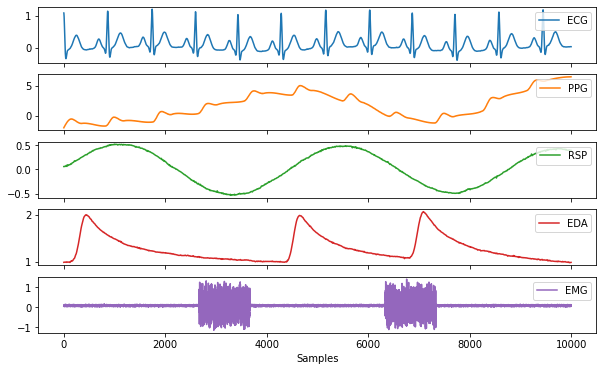

In [8]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt

# Generate synthetic signals
ecg = nk.ecg_simulate(duration=10, heart_rate=70)
ppg = nk.ppg_simulate(duration=10, heart_rate=70, motion_amplitude=10)
rsp = nk.rsp_simulate(duration=10, respiratory_rate=15)
eda = nk.eda_simulate(duration=10, scr_number=3)
emg = nk.emg_simulate(duration=10, burst_number=2)

# Visualise biosignals
data = pd.DataFrame({"ECG": ecg,
                     "PPG": ppg,
                     "RSP": rsp,
                     "EDA": eda,
                     "EMG": emg})

plt.rcParams['figure.figsize'] = [10, 6]  # resize

nk.signal_plot(data, subplots=True)

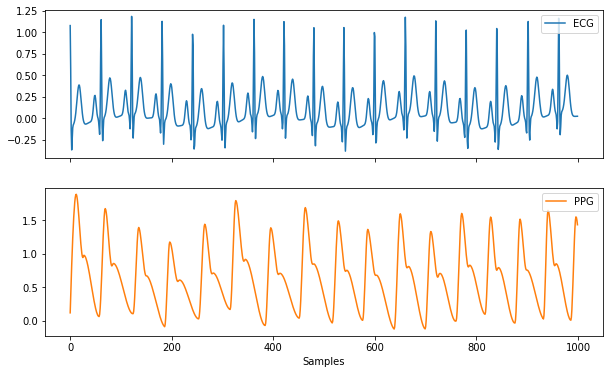

In [81]:
ppg = nk.ppg_simulate(duration=100, heart_rate=70, motion_amplitude=0.1, sampling_rate=70, powerline_amplitude=0.4)
ecg = nk.ecg_simulate(duration=100, heart_rate=70, sampling_rate=70)
data = pd.DataFrame({"ECG": ecg,
                     "PPG": ppg})

plt.rcParams['figure.figsize'] = [10, 6]  # resize

nk.signal_plot(data[0:1000], subplots=True)

In [ ]:
x = [x for x in range(0,len(ppg)//256)]
x

### Generate Data

In [161]:
ppg1 = nk.ppg_simulate(duration=1000, heart_rate=70, motion_amplitude=0.1, sampling_rate=70, powerline_amplitude=0.4)
ppg2 = nk.ppg_simulate(duration=1000, heart_rate=70, motion_amplitude=0.1, sampling_rate=70, powerline_amplitude=0.4)
ecg = nk.ecg_simulate(duration=1000, heart_rate=70, sampling_rate=70)
X1 = np.asarray([ppg1[i:i+features] for i in range(0,len(ppg1)//256)])
X2 = np.asarray([ppg2[i:i+features] for i in range(0,len(ppg2)//256)])
X3 = np.asarray([ecg[i:i+features] for i in range(0,len(ecg)//256)])

In [158]:
def generate_data(X1, X2, X3, n_samples):
  # choose random instances
  Xa = []
  Xb = []
  y = []
  ix = randint(0, np.shape(X1)[0], n_samples//2)
  # Generate simimlar pair --> Y = 1
  for i in ix :
    Xa.append(X1[i])
    Xb.append(X2[i])
    y.append(1)
  
  ix = randint(0, np.shape(X1)[0], n_samples//2)
  # Generate simimlar pair --> Y = 1
  for i in ix :
    Xa.append(X1[i])
    Xb.append(X3[i])
    y.append(0) 
  Xa = np.asarray(Xa)
  Xb = np.asarray(Xb)
  y = np.asarray(y)
  y = np.expand_dims(y, axis = 1)
  return Xa, Xb, y


In [112]:
np.shape(X1)

(273, 256)

In [130]:
# Generate training data
Xa, Xb, y = generate_data(X1,X2,X3,100)

In [162]:
# Generate test
Xta, Xtb, ytest = generate_data(X1,X2,X3,100)

### Generate model

In [159]:
features =256
sm = Siamese_model(features)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Training

In [160]:
sm.fit([Xa, Xb], y, epochs=500, batch_size=20, shuffle=True, verbose=True)

Epoch 1/500
5/5 [==============================] - 1s 6ms/step - loss: 2.7009 - accuracy: 0.5300
Epoch 2/500
5/5 [==============================] - 0s 5ms/step - loss: 2.3795 - accuracy: 0.5800
Epoch 3/500
5/5 [==============================] - 0s 7ms/step - loss: 2.0613 - accuracy: 0.5800
Epoch 4/500
5/5 [==============================] - 0s 6ms/step - loss: 1.8514 - accuracy: 0.6300
Epoch 5/500
5/5 [==============================] - 0s 8ms/step - loss: 1.2520 - accuracy: 0.6300
Epoch 6/500
5/5 [==============================] - 0s 5ms/step - loss: 1.5144 - accuracy: 0.6300
Epoch 7/500
5/5 [==============================] - 0s 7ms/step - loss: 1.2300 - accuracy: 0.6100
Epoch 8/500
5/5 [==============================] - 0s 6ms/step - loss: 1.2529 - accuracy: 0.6400
Epoch 9/500
5/5 [==============================] - 0s 7ms/step - loss: 0.9398 - accuracy: 0.6700
Epoch 10/500
5/5 [==============================] - 0s 5ms/step - loss: 0.9094 - accuracy: 0.7100
Epoch 11/500
5/5 [===========

In [135]:
sm.train_on_batch([Xa, Xb],y)

[1.9872610569000244, 0.47999998927116394]

In [139]:
features =256
i = 60
inp1 = ppg[0:features]
inp2 = ecg[i:i+ features]
#inp1 = random(features)
#inp2 = random(features)
inp1 = np.expand_dims(inp1, axis = 0)
inp2 = np.expand_dims(inp2, axis = 0)
#sm = Siamese_model(features)
#inp1 = randn()
#sm.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape', 'cosine'])
#sm.fit([Xa, Xb], y, epochs=500, batch_size=5, shuffle=True, verbose=True)
score = sm(inputs= [inp1, inp2])
print(score)

tf.Tensor([[0.07633948]], shape=(1, 1), dtype=float32)


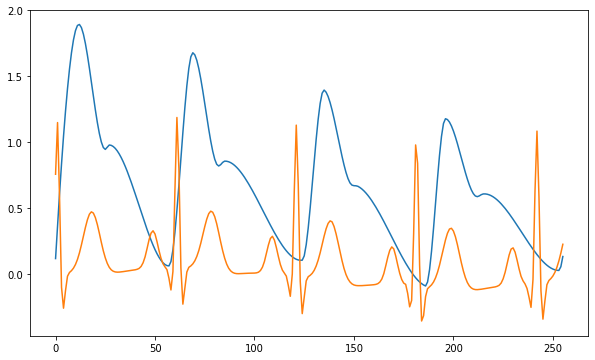

In [98]:
plt.plot(inp1[0,:])
plt.plot(inp2[0,:])

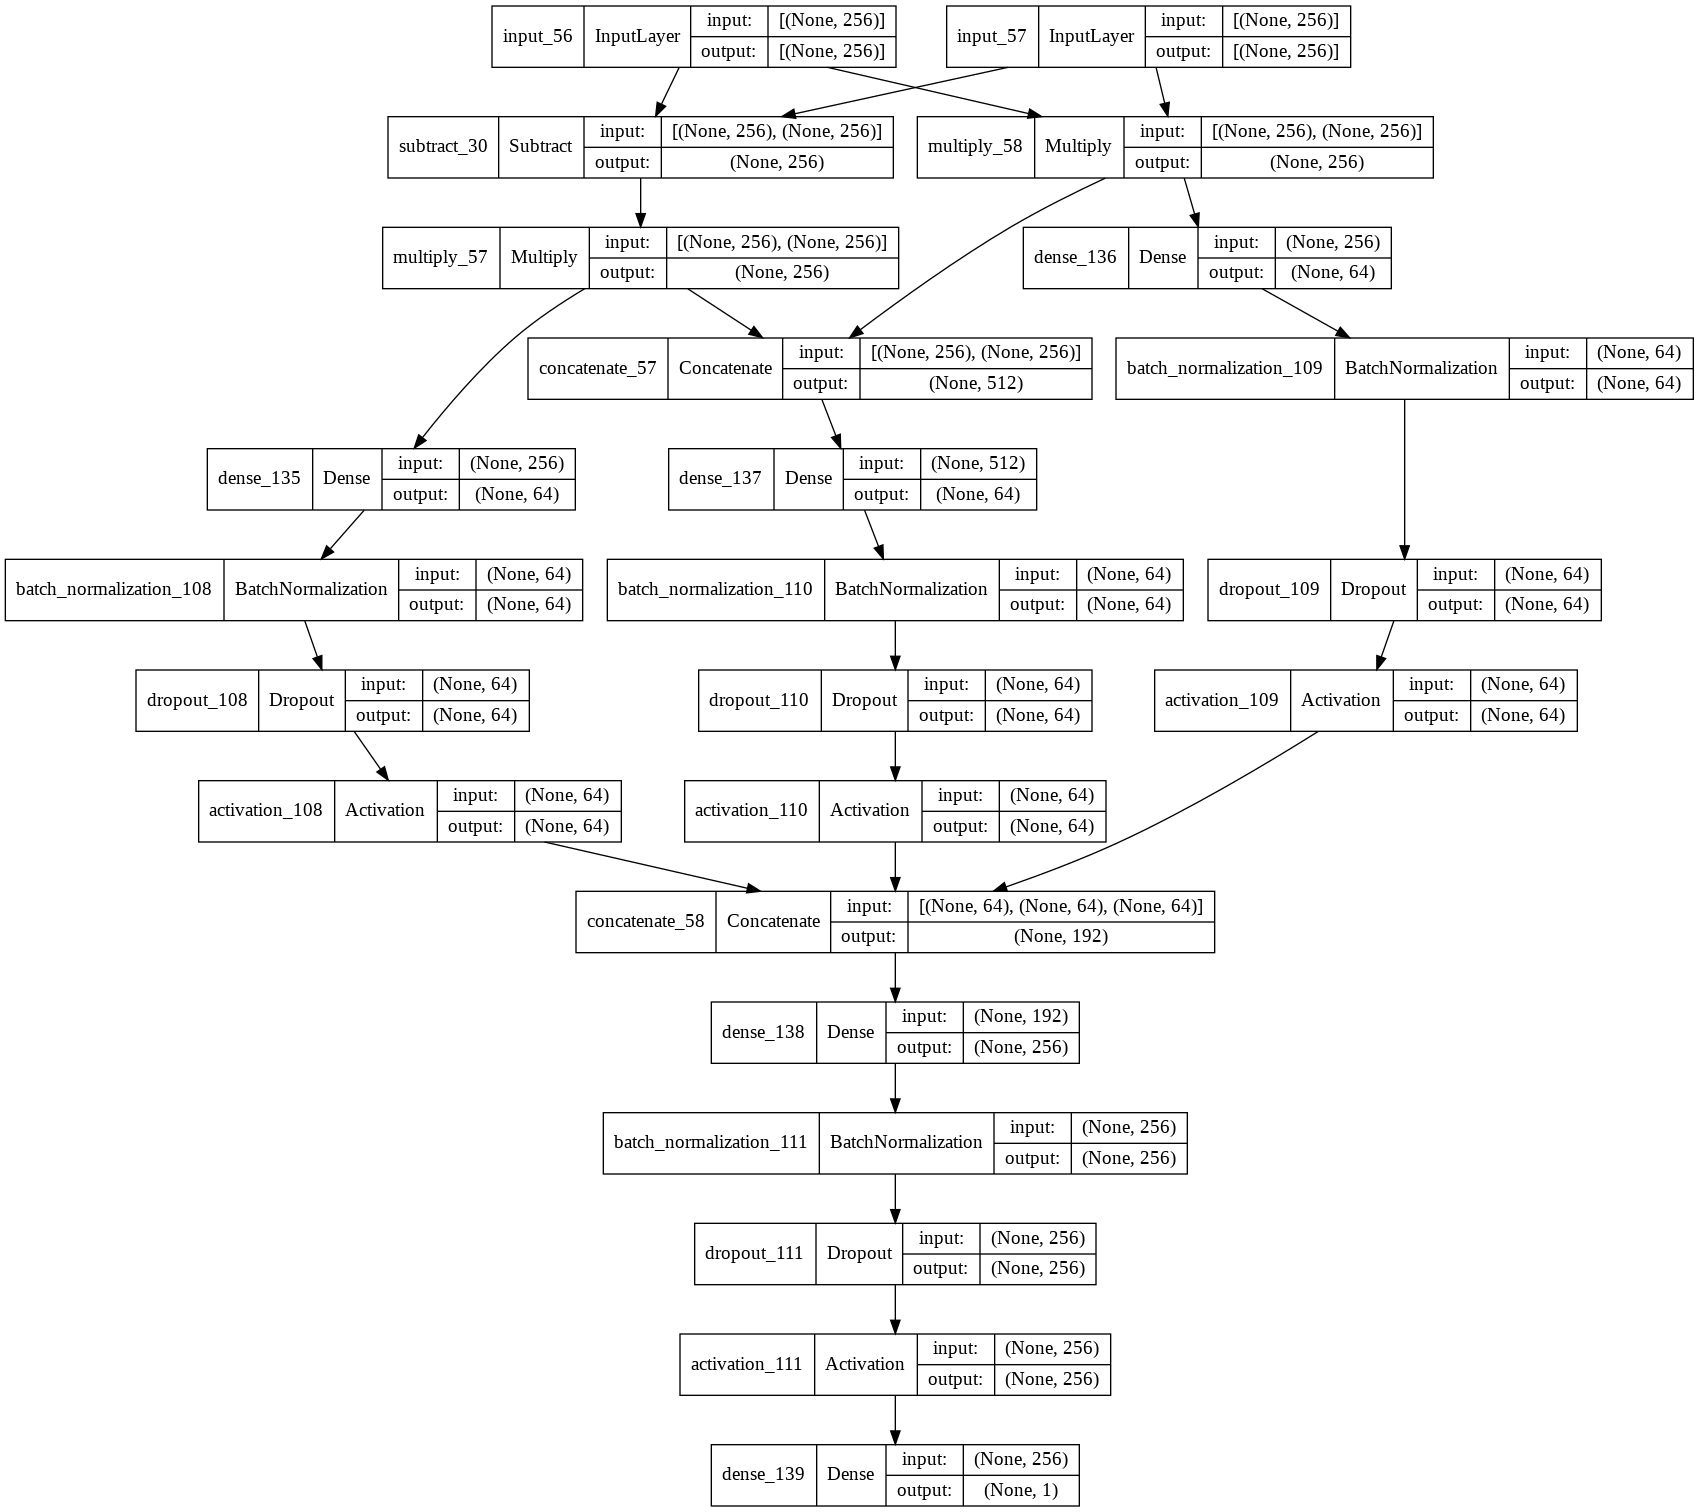

In [134]:
plot_model(sm, to_file='siameseModel.png', show_shapes=True,
show_layer_names=True)

### Predict

In [163]:
ypred = sm.predict([Xta,Xtb])

### Convert to label {0,1}

In [165]:
ypred1  = [1 if ele>0.5 else 0 for ele in ypred]


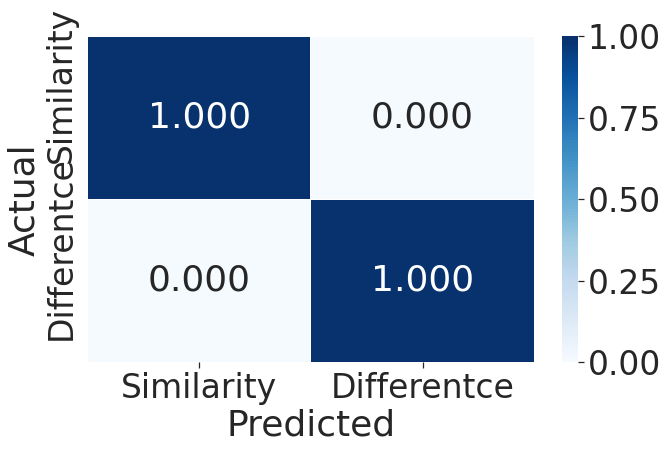

In [168]:
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import numpy as np
#cm = [[0.98868458, 0.00708215, 0.00500835],
#       [0.00565771, 0.99008499, 0.00500835],
#       [0.01697313, 0.00424929, 0.97495826]];
cm = confusion_matrix(np.squeeze(ytest), ypred1)
# Normalise
colormap = sns.color_palette("Blues", 110) 
class_names = ['Similarity', 'Differentce']
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#fig, ax = plt.subplots(figsize=(10,8.9))
tick_marks = np.arange(len(class_names))
#plt.xticks(tick_marks, class_names, rotation=45)
#plt.yticks(tick_marks, class_names)
#plt.figure(dpi=300)
#fig = plt.figure(figsize=(18,15),dpi=1200)


sns.heatmap(cmn, annot=True, fmt='.3f',linewidths = 0.1, xticklabels=class_names, yticklabels=class_names, cmap=colormap)
sns.set(font_scale=3)
#plt.xticks( tick_marks + 0.5, class_names, rotation=0)
#ax.xaxis.set_minor_locator(MaxNLocator(6))

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

plt.yticks( tick_marks + 0.30, class_names,rotation=90)
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.show(block=True)